# AEWS Python Notebook 08b: AEWS miscellanea

**Author**: Eric Lehmann, CSIRO Data61  
**Date**: June 07, 2016.

**Note**: The Python code below is "rudimentary" etc. etc. Priority is here given to code interpretability rather than execution efficiency.

**Note**: this notebook should be accessible and viewable at [https://github.com/eric542/agdc_v2/tree/master/notebooks](https://github.com/eric542/agdc_v2/tree/master/notebooks).

## Summary

Building up on the concepts introduced in the previous notebooks in this series, we work out the remaining components of the AEWS implementation -- see *'AEWS Python Notebook 08a'* for details of these components. The contents summary for the present notebook is given below.

**Abstract $-$** Various aspects of the AEWS rely on the knowledge of how the Landsat has been processed and how it is presented to the user, in terms of data values and range. For instance, the SWIR "glint" filter uses a threshold set to 1% of the SWIR2 band values. The red/amber/green flags will also ultimately require the definition of gren/amber and amber/red thresholds, which will depend on the specific range of values in the SWIR2 band. In the notebook below (08b), we check the basic assumptions and characteristics of the Landsat data in that context. In the process, we also deal with the (previously not encountered) issue of "empty" time slices, where some dates contain only NaN's. We also present a possible way to display the final water quality (turbidity) information in conjunction with the red/amber/green flagging system.

## Preliminaries

This (Jupyter) notebook was written for use on the NCI's VDI system, with the following pre-loaded module:

```
 $ module use /g/data/v10/public/modules/modulefiles --append
 $ module load agdc-py2-prod 
```

**NOTE**: the specific module loaded here (`agdc-py2-prod`) is different from the module loaded in earlier notebooks (`agdc-py2-dev`)! While the earlier module contained only Landsat 5 data, the `agdc-py2-prod` module links to a (different) AGDC database containing the following NBART/NBAR/PQA datasets:

* Landsat 8: 2013
* Landsat 7: 2013
* Landsat 5: 2006/2007

It is unclear whether the API functions in these 2 modules are identical or represent different versions.

In [1]:
%%html  # Definitions for some pretty text boxes...
<style>
    div.warn { background-color: #e8c9c9; border-left: 5px solid #c27070; padding: 0.5em }
    div.note { background-color: #cce0ff; border-left: 5px solid #5c85d6; padding: 0.5em }
    div.info { background-color: #ffe680; border-left: 5px solid #cca300; padding: 0.5em }
</style>

In [2]:
%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import ogr
import json

from matplotlib.colors import LinearSegmentedColormap

from pylab import rcParams
rcParams['figure.figsize'] = (10,10)   # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False   # disable scalar formatter / offset in axes labels

from pprint import pprint
from __future__ import print_function

import datacube.api   # import the AGDC v2 API, with pre-loaded 'agds-py2-dev' (or similar) NCI module
from datacube.analytics.analytics_engine import AnalyticsEngine
from datacube.execution.execution_engine import ExecutionEngine

def scale_array(arr, prcnt, min_val, max_val, nan_val):
    # Function: Linearly scales array 'arr' at the 'prcnt' percentile between 'min_val'
    # and 'max_val', replacing 'nan_val' values with NumPy NaN's.
    f_arr = arr.astype('float') # required for NaN's
    if not np.isnan(nan_val): f_arr[f_arr==nan_val] = np.nan
    prcnt_delta = (100-prcnt)/2
    clip_lim = np.nanpercentile(f_arr,(prcnt_delta,100-prcnt_delta))
    f_arr = np.clip(f_arr,clip_lim[0],clip_lim[1])
    f_arr = (f_arr-clip_lim[0]) / (clip_lim[1]-clip_lim[0])
    f_arr = f_arr * (max_val-min_val) + min_val
    return f_arr

Let's define a function with the code presented in _"AEWS Python Notebook 06"_ used to deal with same-day datasets (now updated to deal with `xarray.DataArray`s directly):

In [3]:
def merge_dup_dates(xada):
    # Takes in an xarray.DataArray 'xada' as input and merges 
    # datasets (time slices) within it that have the same dates.
    # Returns the modified DataArray and vector of selected dates.
    dates = xada.coords['time'].values
    n_dates = len( dates )
    
    # Convert UTM times to local dates (d/m/y only):
    str_dates = np.zeros(n_dates).astype('str')
    for ii in range(n_dates):
        str_dates[ii] = str( dates[ii] )[:10]
    
    # Remove duplicated dates:
    rem_ind = np.zeros(n_dates).astype('bool')   # keep track of which duplicated dates to remove
    for ind in range(1,n_dates):
        dup_ind = np.where( str_dates[:ind]==str_dates[ind] )[0]   # check for duplicated date up to current index
        if len( dup_ind )!=0:   # found (at least) one duplicate
            dup_ind = dup_ind[0]   # only use the first index if multiple dates returned
            rem_ind[ind] = True    # remove current date index
            ind_n_nans = np.sum( np.isnan( xada[ind] ) ) # nr of NaN pixels in each image
            dup_n_nans = np.sum( np.isnan( xada[dup_ind] ) )
            if ind_n_nans==0:     # current data has no NaN's, use it instead of duplicate date (copy it to lowest index)
                xada[dup_ind] = xada[ind]
            elif dup_n_nans!=0:   # if duplicate date has no NaN's: do nothing (use it instead of current date)
                if dup_n_nans<ind_n_nans:   # duplicate date has less NaN's: fill it in with current data
                    tmp = np.where( np.isnan(xada[dup_ind]) )
                    xada[dup_ind].values[tmp] = xada[ind].values[tmp]
                else:   # dup_n_nans>=ind_n_nans -- duplicate date has more NaN's: use it to fill in current data
                    tmp = np.where( np.isnan(xada[ind]) )
                    xada[ind].values[tmp] = xada[dup_ind].values[tmp]
                    xada[dup_ind] = xada[ind]   # save results to lowest date index, in case >2 slices have same date
    
    return xada[~rem_ind]

## Loading some L8 data

Let's load some Landsat 8 data, and perform the usual processing to remove duplicate dates and empty time slices. To this aim, we'll be using the above defined function `merge_dup_dates()`, and will be manually checking and removing the empty time slices.

**Important**: due to the availability of the Coastal Aerosol band in LS8 (not available in LS5,7), the "usual" Landsat bands are offset by one. For instance, the "usual" (green) band nr. 2 corresponds to 'band_3' in LS8. A description of the bands and their spectral contents can be found e.g. here for Landsat 8 (similar links for LS5,7):
https://github.com/data-cube/agdc-v2/blob/develop/docs/config_samples/ga_landsat_8/ls8_albers.yaml  
<br>
<div class=warn>
<b>WARNING:</b> the handling of Landsat bands and band indices is different between LS5,7 and LS8.
</div>

In [4]:
dimensions = { 'longitude': {'range': (149.06, 149.17)},    # selected region
               'latitude':  {'range': (-35.33, -35.27)},
               'time':      { 'range': ((2013, 1, 1), (2014, 1, 1))} }

In [5]:
ae = AnalyticsEngine()
ee = ExecutionEngine()

aeB2 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_3'], dimensions, 'aeB2')
aeB3 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_4'], dimensions, 'aeB3')
aeB4 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_5'], dimensions, 'aeB4')
aeB5 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_6'], dimensions, 'aeB5')
aeB7 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_7'], dimensions, 'aeB7')   # SWIR2 band
aePQ = ae.create_array(('LANDSAT_8', 'pqa'), ['pixelquality'], dimensions, 'aePQ')
aeWQ = ae.apply_expression([aeB2, aeB3], '((array1 + array2) * 0.5)', 'aeWQ')
aeWQ_PQmsk = ae.apply_expression([aeWQ, aePQ], 'array1{array2}', 'aeWQ_PQmsk')
ee.execute_plan(ae.plan)

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


In [6]:
# Merge datasets with duplicated dates:
B2_xarray = ee.cache['aeB2']['array_result'].values()[0]  # 'band_3' ...!
B2_xarray = merge_dup_dates( B2_xarray.load() )

B3_xarray = ee.cache['aeB3']['array_result'].values()[0]  # 'band_4' ...!
B3_xarray = merge_dup_dates( B3_xarray.load() )

B4_xarray = ee.cache['aeB4']['array_result'].values()[0]  # 'band_5' ...!
B4_xarray = merge_dup_dates( B4_xarray.load() )

B5_xarray = ee.cache['aeB5']['array_result'].values()[0]  # 'band_6' ...!
B5_xarray = merge_dup_dates( B5_xarray.load() )

B7_xarray = ee.cache['aeB7']['array_result'].values()[0]  # 'band_7' ...!
B7_xarray = merge_dup_dates( B7_xarray.load() )

WQ_xarray = ee.cache['aeWQ']['array_result']['aeWQ']
WQ_xarray = merge_dup_dates( WQ_xarray.load() )

WQ_pqm_xarray = ee.cache['aeWQ_PQmsk']['array_result']['aeWQ_PQmsk']
WQ_pqm_xarray = merge_dup_dates( WQ_pqm_xarray.load() )

An aspect that did not transpire in earlier notebooks is that the dataset might still contain time slices with no valid data (NaN only). This is likely due to data available from neighbouring paths, rather than neighbouring scenes (which the function `merge_dup_dates()` essentially deals with), but the API functions do not automatically remove those slices if filled with NaNs. 

We can check this by determining which time slices are filled with NaNs:

In [7]:
tmp = ~np.isnan(B2_xarray)    # check which values are non-NaN for each time slice, x and y
tmp = tmp.sum('x').sum('y')   # total number of non-NaN values in each time slice
( tmp==0 ).values   # for each time slice, check whether the nr of non-NaN values is 0 ("empty" time slice)

array([ True, False, False, False, False, False, False,  True, False,
       False,  True, False, False,  True, False, False,  True, False,
       False,  True, False, False,  True, False, False,  True, False,
        True, False, False, False, False, False, False, False,  True,
       False, False, False], dtype=bool)

<div class=note>
<b>NOTE:</b> time slices returned by the AGDC v2.0 API may not contain any valid data and should be checked prior to further processing.
</div>

We will have to remove those "empty" time slices manually (i.e. until a "fix" is implemented by the AGDC development team):

In [8]:
valid_indx = np.where( ( (~np.isnan(B2_xarray)).sum('x').sum('y')!=0 ).values )[0] 
B2_xarray = B2_xarray[valid_indx]

tmp = np.where( ( (~np.isnan(B3_xarray)).sum('x').sum('y')!=0 ).values )[0]
if not (valid_indx==tmp).all(): print( "B3: Valid dates discrepancy found!" )   # should be identical between bands!...
B3_xarray = B3_xarray[tmp]

tmp = np.where( ( (~np.isnan(B4_xarray)).sum('x').sum('y')!=0 ).values )[0]
if not (valid_indx==tmp).all(): print( "B4: Valid dates discrepancy found!" )
B4_xarray = B4_xarray[tmp]

tmp = np.where( ( (~np.isnan(B5_xarray)).sum('x').sum('y')!=0 ).values )[0]
if not (valid_indx==tmp).all(): print( "B5: Valid dates discrepancy found!" )
B5_xarray = B5_xarray[tmp]

tmp = np.where( ( (~np.isnan(B7_xarray)).sum('x').sum('y')!=0 ).values )[0]
if not (valid_indx==tmp).all(): print( "B7: Valid dates discrepancy found!" )
B7_xarray = B7_xarray[tmp]

tmp = np.where( ( (~np.isnan(WQ_xarray)).sum('x').sum('y')!=0 ).values )[0]
if not (valid_indx==tmp).all(): print( "WQ: Valid dates discrepancy found!" )
WQ_xarray = WQ_xarray[tmp]

tmp = np.where( ( (~np.isnan(WQ_pqm_xarray)).sum('x').sum('y')!=0 ).values )[0]
WQ_pqm_xarray = WQ_pqm_xarray[tmp]   # more dates could need removing due to cloud masking

And for some visual candy effects, let's show some pretty plots of the data, now that we have a "clean" dataset...

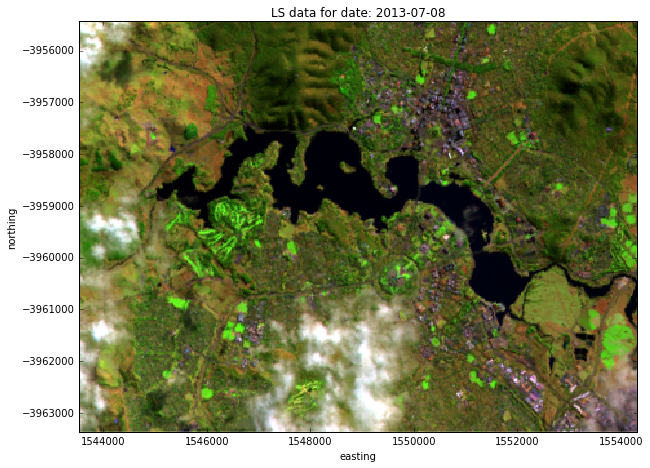

In [9]:
date_ind = 8   # selected date index
sB2data = scale_array(B2_xarray[date_ind].values, 99.0, 0, 255, np.nan)
sB4data = scale_array(B4_xarray[date_ind].values, 99.0, 0, 255, np.nan)
sB5data = scale_array(B5_xarray[date_ind].values, 99.0, 0, 255, np.nan)
FC_image = np.zeros((B2_xarray.shape[1], B2_xarray.shape[2], 3), dtype='uint8')
FC_image[:,:,0] = sB5data; FC_image[:,:,1] = sB4data; FC_image[:,:,2] = sB2data

xvec = B2_xarray.coords['x']; yvec = B2_xarray.coords['y']
plt.imshow(FC_image, interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
plt.title( 'LS data for date: {}'.format(str(B2_xarray.coords['time'][date_ind].values)[:10]) )
plt.ylabel('northing'); plt.xlabel('easting');

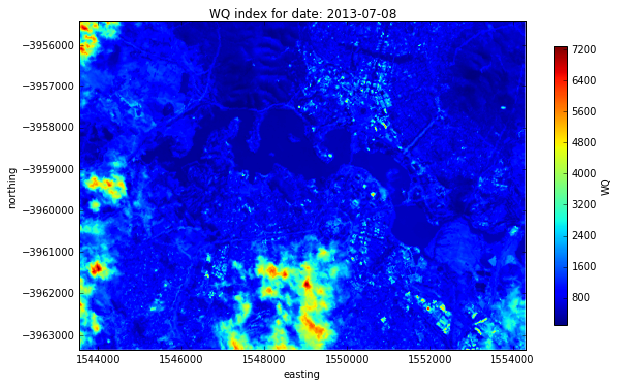

In [10]:
plt.imshow( WQ_xarray[date_ind], interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
plt.title( 'WQ index for date: {}'.format(str(WQ_xarray.coords['time'][date_ind].values)[:10]) )
plt.ylabel('northing'); plt.xlabel('easting')
plt.colorbar(orientation='vertical', shrink=0.5, label='WQ');

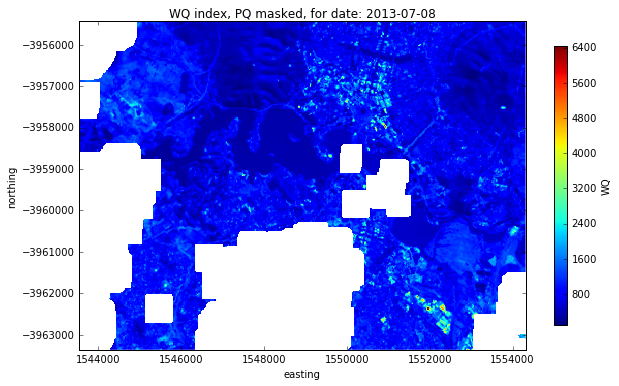

In [11]:
ind = 5   # in the PQ masked dataset, some of the original dates ended up with NaNs everywhere due to clouds, 
          # and were thus removed from the 'time series'; we thus have to select a different index here.
plt.imshow( WQ_pqm_xarray[ind], interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
plt.title( 'WQ index, PQ masked, for date: {}'.format(str(WQ_pqm_xarray.coords['time'][ind].values)[:10]) )
plt.ylabel('northing'); plt.xlabel('easting')
plt.colorbar(orientation='vertical', shrink=0.5, label='WQ');

## Working out pixel values

In order to implement the SWIR filter and Red/Amber/Green flags in the context of AEWS, we need to know roughly what type of data are provided by the AGDC API / database, as well as their range. 

The data contained in the xArrays provided by the AE/EE appear to be floating point numbers:

In [12]:
ee.cache['aeB2']['array_result'].values()[0].dtype

dtype('float64')

However, we know that the data is originally contained as 16-bit integer (`int16`) format, see e.g. https://github.com/data-cube/agdc-v2/blob/develop/docs/config_samples/ga_landsat_8/ls8_albers.yaml.

The data has likely been converted to floating point number, and we should at double-check whether any kind of re-scaling or offsetting has been applied. We'll use our L8 database above (29 dates in total in 2013), which includes both a deep lake and clouds; that should give us a good idea about the range of values in the dataset.

First, let's check that the data is still in integer form (despite its floating point format): let's add up all the fractional parts of the data values (for all bands, dates, x and y), and see if that's different from zero.

In [13]:
print(B2_xarray.shape)
tmp = (B2_xarray % 1) + (B3_xarray % 1) + (B4_xarray % 1) + (B5_xarray % 1) + (B7_xarray % 1)
tmp.sum(('x','y','time')).values

(29, 318, 432)


array(0.0)

This doesn't check for every single value in the AGDC database, but it indicates that the fractional value of (up to) 19,919,520 (= 29 x 318 x 432 x 5, with some missing ones due to NaNs) LS8 pixels is 0. Pretty convincing to me...

Now let's check the range of LS8 values. The L8 data comes off the satellite as 12-bit integers, with the USGS documentation (http://landsat.usgs.gov/landsat8.php) indicating that the USGS L8 products are provided as 16-bit data. This would point to a data range between 0 and $2^{12} - 1 = 4095$. 

A discussion with the GA team revealed that apparently, all NBAR data in the AGDC database has been scaled to be within the range 1 ... 10,000 (see also [this document](https://data-cube.slack.com/files/andrewhicks/F1C67U9C0/australian_reflectance_grid__arg25__product_description_-_v1_1.pdf)). The following tests seem to corroborate this.

In [14]:
print( "Array min / max:", B2_xarray.min(('x','y','time')).values, "...", B2_xarray.max(('x','y','time')).values )
print( "Array min / max:", B3_xarray.min(('x','y','time')).values, "...", B3_xarray.max(('x','y','time')).values )
print( "Array min / max:", B4_xarray.min(('x','y','time')).values, "...", B4_xarray.max(('x','y','time')).values )
print( "Array min / max:", B5_xarray.min(('x','y','time')).values, "...", B5_xarray.max(('x','y','time')).values )
print( "Array min / max:", B7_xarray.min(('x','y','time')).values, "...", B7_xarray.max(('x','y','time')).values )

Array min / max: 10.0 ... 10000.0
Array min / max: 10.0 ... 10000.0
Array min / max: 10.0 ... 10000.0
Array min / max: 9.0 ... 10000.0
Array min / max: 9.0 ... 10000.0


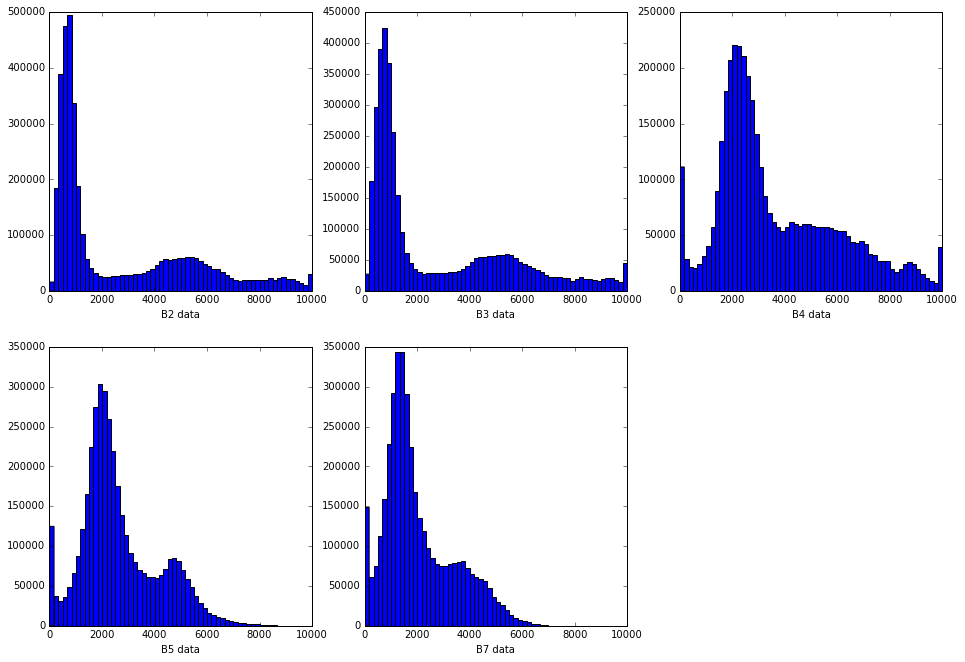

In [15]:
plt.figure( figsize=(16,11) )

plt.subplot( 2,3,1 )
tmp = B2_xarray.values.flatten(); tmp = tmp[~np.isnan(tmp)]
plt.hist(tmp, bins=60); plt.xlabel("B2 data")

plt.subplot( 2,3,2 )
tmp = B3_xarray.values.flatten(); tmp = tmp[~np.isnan(tmp)]
plt.hist(tmp, bins=60); plt.xlabel("B3 data")

plt.subplot( 2,3,3 )
tmp = B4_xarray.values.flatten(); tmp = tmp[~np.isnan(tmp)]
plt.hist(tmp, bins=60); plt.xlabel("B4 data")

plt.subplot( 2,3,4 )
tmp = B5_xarray.values.flatten(); tmp = tmp[~np.isnan(tmp)]
plt.hist(tmp, bins=60); plt.xlabel("B5 data");

plt.subplot( 2,3,5 )
tmp = B7_xarray.values.flatten(); tmp = tmp[~np.isnan(tmp)]
plt.hist(tmp, bins=60); plt.xlabel("B7 data");

## Landsat 5 & 7

We will very likely get the same results, but for completeness, we should also "test" the type and range of values for Landsat 5 and Landsat 7 data...

### Landsat 7

In [16]:
ae = AnalyticsEngine(); ee = ExecutionEngine()
LSbnd = ae.create_array(('LANDSAT_7', 'nbar'), ['band_2'], dimensions, 'LSbnd')
ee.execute_plan(ae.plan)

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


In [17]:
LS_xarray = ee.cache['LSbnd']['array_result'].values()[0]
LS_xarray = merge_dup_dates( LS_xarray.load() )   # merge duplicate dates
tmp = np.where( ( (~np.isnan(LS_xarray)).sum('x').sum('y')!=0 ).values )[0]   # remove empty time slices
LS_xarray = LS_xarray[tmp]

In [18]:
print( "Nr. of time slices:", LS_xarray.shape[0] )
print( "Sum of fractional parts:", (LS_xarray % 1).sum(('x','y','time')).values )
print( "Array min / max:", B2_xarray.min(('x','y','time')).values, "...", B2_xarray.max(('x','y','time')).values )

Nr. of time slices: 26
Sum of fractional parts: 0.0
Array min / max: 10.0 ... 10000.0


### Landsat 5

In [19]:
dimensions = { 'longitude': {'range': (149.06, 149.17)},    # selected region
               'latitude':  {'range': (-35.33, -35.27)},
               'time':      { 'range': ((2006, 1, 1), (2007, 1, 1))} }

In [20]:
ae = AnalyticsEngine(); ee = ExecutionEngine()
LSbnd = ae.create_array(('LANDSAT_5', 'nbar'), ['band_2'], dimensions, 'LSbnd')
ee.execute_plan(ae.plan)

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


In [21]:
LS_xarray = ee.cache['LSbnd']['array_result'].values()[0]
LS_xarray = merge_dup_dates( LS_xarray.load() )   # merge duplicate dates
tmp = np.where( ( (~np.isnan(LS_xarray)).sum('x').sum('y')!=0 ).values )[0]   # remove empty time slices
LS_xarray = LS_xarray[tmp]

In [22]:
print( "Nr. of time slices:", LS_xarray.shape[0] )
print( "Sum of fractional parts:", (LS_xarray % 1).sum(('x','y','time')).values )
print( "Array min / max:", B2_xarray.min(('x','y','time')).values, "...", B2_xarray.max(('x','y','time')).values )

Nr. of time slices: 38
Sum of fractional parts: 0.0
Array min / max: 10.0 ... 10000.0


Seems like we can be pretty confident that those results are valid across the whole range of Landsat data from the AGDC database.

## SWIR filtering

The results above mean that the SWIR "glint" filter, to be implemented within the AEWS, would use a 1% threshold of 100. Let's try this out... In the present dataset, the LS8 SWIR2 band ('band_7') has been loaded in the variable `B7_xarray`. We'll use the same selected date as above for demonstration purposes.

In [23]:
SWIR_mask = ( B7_xarray[date_ind].values > 100 )

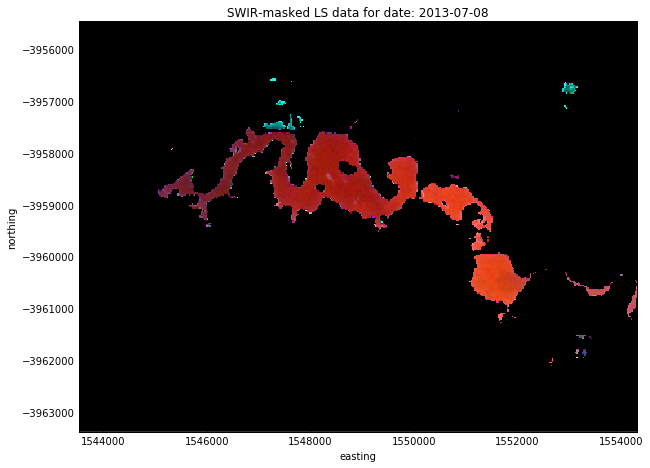

In [24]:
b2 = B2_xarray[date_ind].values.copy(); b2[SWIR_mask] = np.nan
b4 = B4_xarray[date_ind].values.copy(); b4[SWIR_mask] = np.nan
b5 = B5_xarray[date_ind].values.copy(); b5[SWIR_mask] = np.nan

FC_image[:,:,0] = scale_array(b2, 99.0, 0, 255, np.nan)
FC_image[:,:,1] = scale_array(b4, 99.0, 0, 255, np.nan)
FC_image[:,:,2] = scale_array(b5, 99.0, 0, 255, np.nan)

plt.imshow(FC_image, interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
plt.title( 'SWIR-masked LS data for date: {}'.format(str(B2_xarray.coords['time'][date_ind].values)[:10]) )
plt.ylabel('northing'); plt.xlabel('easting');

Not unexpectedly, the SWIR filter has dropped most land pixels, with the resulting RGB display not necessarily super useful over a lake. Let's apply the filtering to the single-band WQ data (of course, this filtering should also be used in combination with the WOFS water filter).

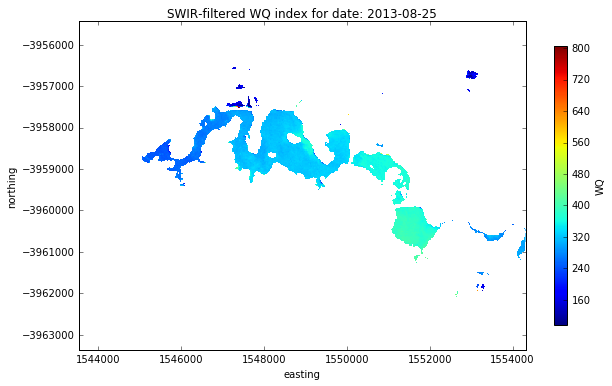

In [25]:
wq = WQ_pqm_xarray[date_ind].values.copy(); wq[SWIR_mask] = np.nan
wq[wq>1400] = np.nan   # ad hoc: as we're not using proper WOFS masking, some WQ pixels (not masked by 
                       # the SWIR filter) end up with excessively large values... We'll remove them 
                       # here "artificially" for the sake of demonstration...
plt.imshow( wq, interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
plt.title( 'SWIR-filtered WQ index for date: {}'.format(str(WQ_pqm_xarray.coords['time'][date_ind].values)[:10]) )
plt.ylabel('northing'); plt.xlabel('easting')
plt.colorbar(orientation='vertical', shrink=0.5, label='WQ');

## AEWS Red / Amber / Green flags

Using the WQ data to derive R/A/G AEWS flags will obviously depend on the selection of R/A and A/G thresholds along the range of WQ values. At the time of writing, these thresholds are still being tested and determined in the AEWS context. So here, these thresholds will be selected arbitrarily for demonstration purposes.

In [26]:
GA_thr = 200   # Green --> Amber threshold
AR_thr = 300   # Amber --> Red threshold

Once the threshold are defined, one possible way to display the WQ / turbidity data in conjunction with the R/A/G flags would be to use a threshold-specific colour map, e.g. defined as follows:

In [27]:
vmax = np.nanmax(wq)
cmap = LinearSegmentedColormap.from_list( 'mycmap', [(0.0, 'honeydew'),
                                                     (GA_thr / vmax, 'darkgreen'),
                                                     (GA_thr / vmax, 'papayawhip'),
                                                     (AR_thr / vmax, 'darkorange'),
                                                     (AR_thr / vmax, 'mistyrose'),
                                                     (1.0, 'firebrick')] )

The resulting plot would then display the range of turbidity pixels while at the same time highlighting their R/A/G status:

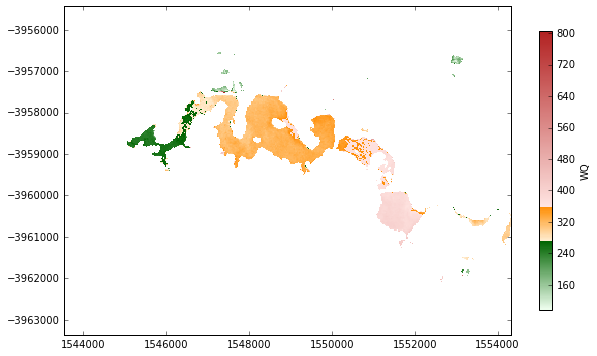

In [28]:
plt.imshow( wq, interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1, cmap=cmap)
plt.colorbar(orientation='vertical', shrink=0.5, label='WQ', cmap=cmap);